**`Challenge #14: Fibonacci sequence in CUDA`**
• Write a CUDA kernel that computes the Fibonacci sequence for N numbers. E.g., N = 220.
• The Fibonacci sequence is a famous mathematical sequence where each number is the sum of the two preceding ones. It starts with 0 and 1, and continues as follows: 0, 1, 1, 2, 3, 5, 8, 13, 21,
34, 55, 89, 144, ...
• The mathematical definition is:
• F(0) = 0
• F(1) = 1
• F(n) = F(n-1) + F(n-2) for N-2 ³ n > 1
• Compare a simple sequential implementation with your CUDA implementation. What do you observe?

In [ ]:
%%writefile fib_profile.cu
#include <cstdio>
#include <cstdlib>
#include <cuda_runtime.h>

// Simple CUDA error checking
#define CUDA_CHECK(call)                                              \
  do {                                                                \
    cudaError_t err = call;                                           \
    if (err != cudaSuccess) {                                         \
      fprintf(stderr, "CUDA error at %s:%d: %s\n",                    \
              __FILE__, __LINE__, cudaGetErrorString(err));           \
      exit(1);                                                        \
    }                                                                 \
  } while (0)

__global__ void fib_kernel(unsigned long long *out, int N) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  if (idx >= N) return;

  if (idx == 0) {
    out[0] = 0ULL;
  } else if (idx == 1) {
    out[1] = 1ULL;
  } else {
    unsigned long long a = 0ULL, b = 1ULL, c;
    for (int i = 2; i <= idx; ++i) {
      c = a + b;
      a = b;
      b = c;
    }
    out[idx] = b;
  }
}

int main() {
  const int N = 1 << 23;  // same N as before
  size_t bytes = N * sizeof(unsigned long long);

  // Allocate host & device
  unsigned long long *h_out = (unsigned long long*)malloc(bytes);
  CUDA_CHECK(h_out ? cudaSuccess : cudaErrorMemoryAllocation);
  unsigned long long *d_out;
  CUDA_CHECK(cudaMalloc(&d_out, bytes));

  // Create events
  cudaEvent_t startKernel, stopKernel, startTotal, stopTotal;
  CUDA_CHECK(cudaEventCreate(&startKernel));
  CUDA_CHECK(cudaEventCreate(&stopKernel));
  CUDA_CHECK(cudaEventCreate(&startTotal));
  CUDA_CHECK(cudaEventCreate(&stopTotal));

  // --- Total start (kernel + D2H) ---
  CUDA_CHECK(cudaEventRecord(startTotal));

  // --- Kernel-only timing ---
  CUDA_CHECK(cudaEventRecord(startKernel));
  const int TPB = 256;
  const int blocks = (N + TPB - 1) / TPB;
  fib_kernel<<<blocks, TPB>>>(d_out, N);
  CUDA_CHECK(cudaGetLastError());
  CUDA_CHECK(cudaEventRecord(stopKernel));
  CUDA_CHECK(cudaEventSynchronize(stopKernel));

  float kernelMs = 0.f;
  CUDA_CHECK(cudaEventElapsedTime(&kernelMs, startKernel, stopKernel));

  // --- Copy result back & stop total timer ---
  CUDA_CHECK(cudaMemcpy(h_out, d_out, bytes, cudaMemcpyDeviceToHost));
  CUDA_CHECK(cudaEventRecord(stopTotal));
  CUDA_CHECK(cudaEventSynchronize(stopTotal));

  float totalMs = 0.f;
  CUDA_CHECK(cudaEventElapsedTime(&totalMs, startTotal, stopTotal));

  // Print verification and timings
  printf("F(0..9):");
  for (int i = 0; i < 10; ++i) {
    printf(" %llu", h_out[i]);
  }
  printf("\nKernel-only time: %.3f ms\n", kernelMs);
  printf("End-to-end time:  %.3f ms\n", totalMs);

  // **Print final value**
  printf("Final F(%d) = %llu\n", N-1, h_out[N-1]);

  // Cleanup
  CUDA_CHECK(cudaFree(d_out));
  free(h_out);
  CUDA_CHECK(cudaEventDestroy(startKernel));
  CUDA_CHECK(cudaEventDestroy(stopKernel));
  CUDA_CHECK(cudaEventDestroy(startTotal));
  CUDA_CHECK(cudaEventDestroy(stopTotal));
  return 0;
}


Overwriting fib_profile.cu


In [ ]:
%%bash
nvcc -O2 fib_profile.cu -arch=sm_75 -o fib_profile
./fib_profile > gpu_output.txt


 C++ “**CPU‐only” version** that computes the same Fibonacci sequence in a simple loop and times it with <chrono>.

In [ ]:
%%writefile fib_seq.cpp
#include <iostream>
#include <vector>
#include <chrono>

int main() {
    const int N = 1 << 23;  // same N as GPU
    std::vector<unsigned long long> fib(N);

    // Time the sequential loop
    auto t0 = std::chrono::high_resolution_clock::now();
    for (int i = 0; i < N; ++i) {
        if (i == 0) {
            fib[i] = 0ULL;
        } else if (i == 1) {
            fib[i] = 1ULL;
        } else {
            fib[i] = fib[i-1] + fib[i-2];
        }
    }
    auto t1 = std::chrono::high_resolution_clock::now();

    double ms = std::chrono::duration<double, std::milli>(t1 - t0).count();

    // Print verification and timing
    std::cout << "F(0..9):";
    for (int i = 0; i < 10; ++i) {
        std::cout << " " << fib[i];
    }
    std::cout << "\nSequential time: "
              << ms << " ms\n";

    // **Print final value**
    std::cout << "Final F(" << N-1 << ") = " << fib[N-1] << "\n";
    return 0;
}


Overwriting fib_seq.cpp


In [ ]:
%%bash
g++ -O2 fib_seq.cpp -o fib_seq
./fib_seq > cpu_output.txt


Python Comparison & Plot

CPU final F: 1943559390643943709
GPU final F: 1943559390643943709


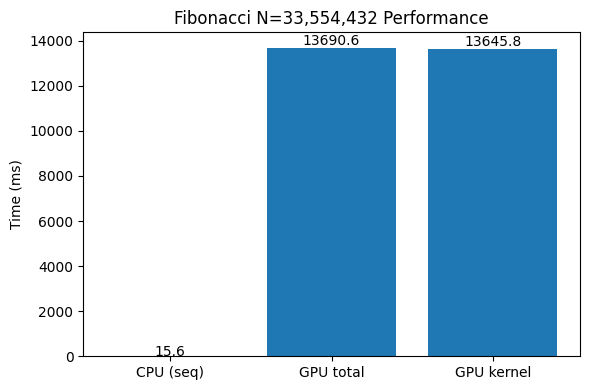

In [ ]:
import re
import subprocess
import matplotlib.pyplot as plt

# Run and capture both outputs
subprocess.run(['./fib_seq'], check=True)
subprocess.run(['./fib_profile'], check=True)

# Read outputs
with open('cpu_output.txt') as f:
    cpu = f.read()
with open('gpu_output.txt') as f:
    gpu = f.read()

# Parse timings
seq_t = float(re.search(r'Sequential time:\s*([\d.]+)\s*ms', cpu).group(1))
gpu_total = float(re.search(r'End-to-end time:\s*([\d.]+)\s*ms', gpu).group(1))
gpu_kernel = float(re.search(r'Kernel-only time:\s*([\d.]+)\s*ms', gpu).group(1))

# Parse final values
seq_final = re.search(r'Final F\(\d+\) = (\d+)', cpu).group(1)
gpu_final = re.search(r'Final F\(\d+\) = (\d+)', gpu).group(1)

print(f"CPU final F: {seq_final}")
print(f"GPU final F: {gpu_final}")
assert seq_final == gpu_final, "Results differ!"

# Plot
labels = ['CPU (seq)', 'GPU total', 'GPU kernel']
times = [seq_t, gpu_total, gpu_kernel]

plt.figure(figsize=(6,4))
plt.bar(labels, times)
plt.ylabel('Time (ms)')
plt.title(f'Fibonacci N={(1<<25):,} Performance')
for i, t in enumerate(times):
    plt.text(i, t*1.01, f'{t:.1f}', ha='center')
plt.tight_layout()
plt.savefig('fib_compare.png')
plt.show()
